The goal of this notebook is to get started with xgboost and apply it to our data.

## Libraries imports

In [1]:
!cp "/content/drive/MyDrive/Statapp/file_04_HMLasso.py" "HMLasso.py"
!cp "/content/drive/MyDrive/Statapp/manipulate_data.py" "manipulate_data.py"

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler # To standardize the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import xgboost as xgb # eXtreme Gradient Boosting
import HMLasso as hml # Lasso with High Missing Rate
import manipulate_data as manip # Useful functions

import time # To measure elapsed time during simulation

## Data imports

In [3]:
columns_types = pd.read_csv("/content/drive/MyDrive/Statapp/data_03_columns_types.csv")
data = pd.read_csv("/content/drive/MyDrive/Statapp/data_03.csv")
data.info(memory_usage="deep")

<ipython-input-3-01047b267827>:2: DtypeWarning: Columns (4146) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Statapp/data_03.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42232 entries, 0 to 42231
Columns: 4161 entries, HHIDPN to GHI14
dtypes: float64(4061), int64(99), object(1)
memory usage: 1.3 GB


## Trying XGBoost

This section is dedicated to the use of XGBoost as a regressor to predict the index.

### Using HMLasso

To speed up the calculations, we made the choice to use the HMLasso to select only a few variables that could be useful. To achieve this subgoal, we first proceed to training the HMLasso on (X, y) where X is the matrix of (HHIDPN, wave) individuals and y is the GHIw.

In [4]:
# Get (X, y)
untimed_data = manip.drop_time(data, keep_genetic=False)
print(untimed_data.info(memory_usage="deep"))

X = untimed_data.drop(columns=["HHIDPN", "GHIw"]).values
y = untimed_data["GHIw"].values

y_scaled = y - y.mean()
X_scaled = StandardScaler().fit_transform(X)

# Fit the HMLasso
hml.ERRORS_HANDLING = "ignore"
lasso = hml.HMLasso(mu = 100, verbose = False)
lasso.fit(X_scaled, y_scaled)

# The lasso dropped some columns. We save the ones that we shall not drop
columns_for_lasso = untimed_data.drop(columns = ["HHIDPN", "GHIw"]).columns
criteria = pd.Series(abs(lasso.beta_opt) > 1e-9)
columns_to_keep = list(pd.Series(columns_for_lasso)[criteria.index[criteria]])

# Loading only individuals present in all waves.
waves = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
columns_to_keep_for_each_wave = [var.replace('w', str(wave)) for var in columns_to_keep for wave in waves] + [var for var in data.columns if 'genetic_' in var]
working_data = manip.get_sample(data, waves = waves)

# We finally select columns agreed by the lasso
working_data = working_data[['HHIDPN'] + columns_to_keep_for_each_wave + [f'GHI{wave}' for wave in range(1, 15)]]
print(working_data.info(memory_usage="deep"))

# Formatting the database and making sure categorical variables are categorical.
variables_per_type = manip.get_columns_types(working_data, columns_types)

working_data[variables_per_type["Char"]] = working_data[variables_per_type["Char"]].astype('category')
working_data[variables_per_type["Categ"]] = working_data[variables_per_type["Categ"]].astype('category')

print(working_data.info(memory_usage="deep"))

FeatureTypes = []
for col in working_data.dtypes:
  if col == "category":
    FeatureTypes.append('c') # 'c' for categorical
  else:
    FeatureTypes.append('q') # 'q' for quantitative

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264618 entries, 0 to 264617
Columns: 192 entries, HHIDPN to GHIw
dtypes: float64(190), int64(2)
memory usage: 387.6 MB
None
[Warning] Sigma_opt is not PSD, its minimum eigenvalue is -9.6303479229307e-06. Error handled by adding 9.6303479229307e-06 to each eigenvalue.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3396 entries, 0 to 3395
Columns: 1500 entries, HHIDPN to GHI14
dtypes: float64(1498), int64(1), object(1)
memory usage: 39.0 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3396 entries, 0 to 3395
Columns: 1500 entries, HHIDPN to GHI14
dtypes: category(855), float64(644), int64(1)
memory usage: 19.7 MB
None


### XGBoost Regressor

In [27]:
def train_model(working_data, data_to_use="all", simulation="short", params_grid=None, how="regressor", n_bins=5, random_state=None, verbose=False):
  """
  Main function to train XGBoost model.
  
  inputs:
  - working_data: the database on which the estimator will be trained and tested.
  - data_to_use:
     > 'all' = socioeconomic data, genetic data, precedent GHI are used for prediction
     > 'socio' = only socioeconomic data are used
     > 'sociogenetic' = only socioeconomic and genetic data are used
     > 'socioghi' = only socioeconomic data and precedent GHI are used
  - simulation:
     > 'short' = only a few hyperparameters will be tested. Does not take more than 10 minutes.
     > 'long' = a lot of hyperparameters will be tested. Can take up to 3h.
  - params_grid: the parameters to cross validate. If this option is specified, simulation is ignored.
  - how:
     > 'regressor' = a XGBRegressor will be trained.
     > 'classifier' = a XGBClassifier will be trained.
    n_bins: number of bins for the classifier. Ignored if how == 'regressor'.
  - random_state: the random_state used in the split train/test.
  - verbose: True or False

  Preferred use: before using this function, apply lasso to select relevant columns.
  """
  assert how in ["regressor", "classifier"]
  if verbose:
    print(how, " model will be fitted.")

  ##############################################################################
  # Creating (X, y)
  ##############################################################################

  ##################### 'data_to_use' handling #################################
  message = {'all' : "Socioeconomic data, genetic data, precedent GHI will be used for prediction.",
             'socio' : "Only socioeconomic data will be used for prediction.",
             'sociogenetic' : "Only socioeconomic data and genetic data will be used for prediction.",
             'socioghi' : "Only socioeconomic data and precedent GHI will be used for prediction."}

  basic_columns = ["genetic_VERSION", "genetic_Section_A_or_E", "HHIDPN", "GHI14"]
  genetic_columns = [col for col in working_data.columns if 'genetic_' in col and col != 'genetic_VERSION' and col != 'genetic_Section_A_or_E']
  GHI_columns = [f'GHI{wave}' for wave in range(1, 14)]

  if data_to_use == 'all':
    columns_to_delete = basic_columns
  elif data_to_use == 'socio':
    columns_to_delete = basic_columns + genetic_columns + GHI_columns
  elif data_to_use == 'sociogenetic':
    columns_to_delete = basic_columns + GHI_columns
  elif data_to_use == 'socioghi':
    columns_to_delete = basic_columns + genetic_columns
  
  if verbose:
    print(message[data_to_use])

  if data_to_use in ['all', 'socio', 'sociogenetic', 'socioghi']:
    X = working_data.drop(columns = columns_to_delete)
  elif data_to_use == 'ghi':
    X = working_data[GHI_columns]

  ############################### select y #####################################
  if how == "regressor":
    y = working_data["GHI14"]
  if how == "classifier":
    y = pd.cut(working_data["GHI14"], n_bins, labels=list(range(n_bins)))

  # Splitting into Training and Testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

  ##############################################################################
  # Performing cross-validation to train and fine-tune the model
  ##############################################################################

  ############################# select model ###################################
  if how == "regressor":
    model = xgb.XGBRegressor(tree_method='gpu_hist', enable_categorical=True, FeatureTypes=FeatureTypes)
  if how == "classifier":
    model = xgb.XGBClassifier(tree_method='gpu_hist', enable_categorical=True, FeatureTypes=FeatureTypes)

  if params_grid is None:
    if simulation == 'long':
      params_grid = {"eta" : [0.1, 0.05, 0.03, 0.01], # learning rate
                    "lambda" : [1, 0.5, 2], # coefficient for L2 penalization
                    "alpha" : [0, 0.5, 1], # coefficient for L1 penalization
                    "max_depth" : [3, 4, 5], # max depth of trees
                    "n_estimators" : [100, 200] # number of trees
                    }
    elif simulation == 'short':
      params_grid = {"eta" : [0.05, 0.03], # learning rate
                    "lambda" : [1, 0.5], # coefficient for L2 penalization
                    "alpha" : [0.5, 1], # coefficient for L1 penalization
                    "max_depth" : [3, 4], # max depth of trees
                    "n_estimators" : [100] # number of trees
                    }

  ########################### select scoring method ############################
  if how == "regressor":
    scoring = 'r2'
  if how == "classifier":
    scoring = 'accuracy'

  ########################### Training the model ###############################
  grid = GridSearchCV(model, params_grid, refit = True, verbose = verbose, n_jobs=-1, scoring=scoring) 
  grid.fit(X_train, y_train)

  results = pd.DataFrame(grid.cv_results_)

  if verbose:
    print("Model refitted with best hyperparameters.")
    print("Best parameters : " + str(grid.best_params_))
    print("R2 score on train : ", str(grid.score(X_train, y_train)))
    print("R2 score on test : ", str(grid.score(X_test, y_test)))
  
  # Storing results
  final_results = {}
  final_results["data"] = data_to_use
  final_results["best_parameters"] = list(grid.best_params_.items())

  y_train_pred = grid.predict(X_train)
  y_test_pred = grid.predict(X_test)
  if how == "regressor":
    final_results["r2_train"] = grid.score(X_train, y_train)
    final_results["r2_test"] = grid.score(X_test, y_test)
    final_results["rmse_train"] = np.sqrt(mean_squared_error(y_train, y_train_pred))
    final_results["rmse_test"] = np.sqrt(mean_squared_error(y_test, y_test_pred))

  if how == "classifier":
    final_results["accuracy_train"] = grid.score(X_train, y_train)
    final_results["accuracy_test"] = grid.score(X_test, y_test)

    final_results["recall_train"] = np.nan
    final_results["recall_test"] = np.nan
    final_results["precision_train"] = np.nan
    final_results["precision_test"] = np.nan
    final_results["f1_train"] = np.nan
    final_results["f1_test"] = np.nan
    if n_bins == 2:
      final_results["recall_train"] = recall_score(y_train, y_train_pred)
      final_results["recall_test"] = recall_score(y_test, y_test_pred)
      final_results["precision_train"] = precision_score(y_train, y_train_pred)
      final_results["precision_test"] = precision_score(y_test, y_test_pred)
      final_results["f1_train"] = f1_score(y_train, y_train_pred)
      final_results["f1_test"] = f1_score(y_test, y_test_pred)

      
    
    recall_score

  return final_results

In [16]:
# SHORT SIMULATION
params_grid_short = {"eta" : [0.05, 0.03], # learning rate
              "lambda" : [1], # coefficient for L2 penalization
              "alpha" : [0.5], # coefficient for L1 penalization
              "max_depth" : [3], # max depth of trees
              "n_estimators" : [100] # number of trees
              }

# LONG SIMULATION
params_grid_long = {"eta" : [0.05, 0.03], # learning rate
               "lambda" : [1, 0.5], # coefficient for L2 penalization
               "alpha" : [0.5, 1], # coefficient for L1 penalization
               "max_depth" : [3, 4], # max depth of trees
               "n_estimators" : [100] # number of trees
              }

# OVERFITTED SIMULATION
params_grid_overfitted = {"eta" : [0.01], # learning rate
               "lambda" : [0.1], # coefficient for L2 penalization
               "alpha" : [0], # coefficient for L1 penalization
               "max_depth" : [10], # max depth of trees
               "n_estimators" : [200] # number of trees
              }

params_grid = {"short" : params_grid_short, "long" : params_grid_long, "overfitted" : params_grid_overfitted}

In [7]:
# Initialize the parameters of the simulation
results_regression = {"Iteration" : [], "Data_used" : [], "best_parameters" : [], "r2_train" : [], "r2_test" : [], "rmse_train" : [], "rmse_test" : []}
speed = "short"
number_of_simulations = 2

t0 = time.time()
for iteration in range(number_of_simulations):

  t_beginning = time.time()

  # We train the model and store the results.
  for data_to_use in ['all', 'socio', 'sociogenetic', 'socioghi', 'ghi']:
    result = train_model(working_data, data_to_use=data_to_use, random_state=None, params_grid=params_grid[speed], how="regressor")
    results_regression["Iteration"].append(iteration)
    results_regression["Data_used"].append(data_to_use)
    results_regression["best_parameters"].append(result["best_parameters"])
    results_regression["r2_train"].append(result["r2_train"])
    results_regression["r2_test"].append(result["r2_test"])
    results_regression["rmse_train"].append(result["rmse_train"])
    results_regression["rmse_test"].append(result["rmse_test"])
    
  t_end = time.time()

  print("iteration: ", iteration, " - elapsed_time: ", t_end - t_beginning)

print("Simulation completed.")
print("Overall elapsed_time = ", time.time() - t0)

# Storing the results
results_regression = pd.DataFrame(results_regression).sort_values("r2_test", ascending=False)
results_regression.to_csv("XGBoost_regression_simulation.csv", index=False)

# Display 
results_regression.groupby(["Data_used"])["r2_test", "rmse_test"].agg({"mean", "std", "count", "max", "min"})

[18:06:24] WARNING: ../src/learner.cc:767: 
Parameters: { "FeatureTypes" } are not used.

[18:06:46] WARNING: ../src/learner.cc:767: 
Parameters: { "FeatureTypes" } are not used.

[18:07:08] WARNING: ../src/learner.cc:767: 
Parameters: { "FeatureTypes" } are not used.

[18:07:29] WARNING: ../src/learner.cc:767: 
Parameters: { "FeatureTypes" } are not used.

[18:07:33] WARNING: ../src/learner.cc:767: 
Parameters: { "FeatureTypes" } are not used.

iteration:  0  - elapsed_time:  93.84320068359375
[18:07:53] WARNING: ../src/learner.cc:767: 
Parameters: { "FeatureTypes" } are not used.

[18:08:14] WARNING: ../src/learner.cc:767: 
Parameters: { "FeatureTypes" } are not used.

[18:08:36] WARNING: ../src/learner.cc:767: 
Parameters: { "FeatureTypes" } are not used.

[18:08:58] WARNING: ../src/learner.cc:767: 
Parameters: { "FeatureTypes" } are not used.

[18:09:02] WARNING: ../src/learner.cc:767: 
Parameters: { "FeatureTypes" } are not used.

iteration:  1  - elapsed_time:  88.74873161315918


<ipython-input-7-8c06933a4728>:34: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results.groupby(["Data_used"])["r2_test", "rmse_test"].agg({"mean", "std", "count", "max", "min"})


r2_test                                      rmse_test  \
                   min       max       std count      mean        min   
Data_used                                                               
all           0.349777  0.401533  0.036597     2  0.375655  40.674771   
ghi           0.296411  0.358583  0.043962     2  0.327497  42.738468   
socio         0.208040  0.228494  0.014463     2  0.218267  47.556871   
sociogenetic  0.170668  0.196625  0.018355     2  0.183646  47.675164   
socioghi      0.309594  0.320150  0.007464     2  0.314872  42.365068   

                                                    
                    max       std count       mean  
Data_used                                           
all           43.938082  2.307509     2  42.306426  
ghi           43.897434  0.819513     2  43.317951  
socio         47.836186  0.197505     2  47.696528  
sociogenetic  49.036692  0.962745     2  48.355928  
socioghi      42.678120  0.221361     2  42.521594

### XGBoost Classifier

Another way to see the problem is to see whether or not XGBoost is able to classify people with respect to their health.

At the end of section 'Using HMLasso', we have the working_data. Let us construct a new variable, namely 'GHC' for 'Global Health Class' with 5 categories.

In [ ]:
# Initialize the parameters of the simulation
results_classification = {"Iteration": [], "n_bins": [], "best_parameters": [], 
                          "accuracy_train" : [], "accuracy_test": [],
                          "recall_train": [], "recall_test": [],
                          "precision_train": [], "precision_test": [],
                          "f1_train": [], "f1_test": []}
speed = "short"
number_of_simulations = 10
n_bins_max = 11

t0 = time.time()
for iteration in range(4, 4+number_of_simulations):

  t_beginning = time.time()

  # We train the model and store the results.
  for n_bins in range(2, n_bins_max):
    result = train_model(working_data, data_to_use='all', random_state=None, params_grid=params_grid[speed], how="classifier", n_bins=n_bins)
    results_classification["Iteration"].append(iteration)
    results_classification["n_bins"].append(n_bins)
    results_classification["best_parameters"].append(result["best_parameters"])
    results_classification["accuracy_train"].append(result["accuracy_train"])
    results_classification["accuracy_test"].append(result["accuracy_test"])
    
    results_classification["recall_train"].append(result["recall_train"])
    results_classification["recall_test"].append(result["recall_test"])
    results_classification["precision_train"].append(result["precision_train"])
    results_classification["precision_test"].append(result["precision_test"])
    results_classification["f1_train"].append(result["f1_train"])
    results_classification["f1_test"].append(result["f1_test"])
    
  t_end = time.time()

  print("iteration: ", iteration, " - elapsed_time: ", t_end - t_beginning)

print("Simulation completed.")
print("Overall elapsed_time = ", time.time() - t0)

# Storing the results
results_classification = pd.DataFrame(results_classification).sort_values("accuracy_test", ascending=False)
results_classification.to_csv("XGBoost_classification_simulation.csv", index=False)

# Display 
results_classification.groupby(["n_bins"])["accuracy_test"].agg({"mean", "std", "count", "max", "min"})

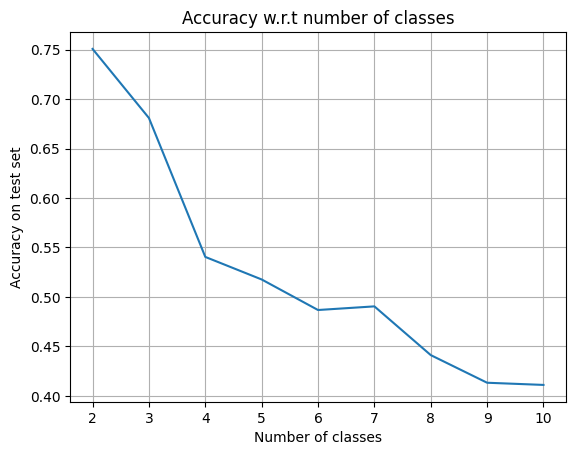

In [71]:
results_classification.groupby(["n_bins"])["accuracy_test"].mean().plot()
plt.grid()
plt.xlabel("Number of classes")
plt.ylabel("Accuracy on test set")
plt.title("Accuracy w.r.t number of classes")
plt.show()